In [20]:
# Import necessary libraries

# Data manipulation
import pandas as pd
import numpy as np

# Statistical functions
from scipy.stats import zscore

# For concurrency (running functions in parallel)
from concurrent.futures import ThreadPoolExecutor

# For caching (to speed up repeated function calls)
from functools import lru_cache

# For progress tracking
from tqdm import tqdm


# Text Preprocessing and NLP
import nltk

# Stopwords (common words to ignore) from NLTK
from nltk.corpus import stopwords

# Tokenizing sentences/words
from nltk.tokenize import word_tokenize

# Part-of-speech tagging
from nltk import pos_tag

# Lemmatization (converting words to their base form)
from nltk.stem import WordNetLemmatizer


# Model Imports
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from gensim.models import Word2Vec

In [1]:
import os
import sys
from pathlib import Path

if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)
os.chdir(workding_dir)
sys.path.append(workding_dir)
print("working dir:", workding_dir)

working dir: /home/inflaton/code/CrediNews


### Load datasets

In [2]:
from datasets import load_dataset, concatenate_datasets, Dataset

datasets = load_dataset(
    "csv",
    data_files={
        "train": [
            "dataset/train_data_1.csv",
            "dataset/train_data_2.csv",
            "dataset/train_data_3.csv",
            "dataset/train_data_4.csv",
        ],
        "test": "dataset/test_data.csv",
        "rewritten_train": [
            "dataset/rewritten_train_data_1.csv",
            "dataset/rewritten_train_data_2.csv",
            "dataset/rewritten_train_data_3.csv",
            "dataset/rewritten_train_data_4.csv",
        ],
        "rewritten_test": "dataset/rewritten_test_data.csv",
    },
)
datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 54441
    })
    test: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 6050
    })
    rewritten_train: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 54441
    })
    rewritten_test: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 6050
    })
})

### LSTM with Word2Vec (best model)

In [3]:
# Set seeds for reproducibility
import tensorflow as tf
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


# Train and process Word2Vec embeddings
def train_word2vec_embeddings(
    train_texts, word_index, max_words=10000, embedding_dim=100
):
    """Tokenizes the text, trains Word2Vec, and creates an embedding matrix."""

    # Tokenizing text into word lists
    sentences = [text.split() for text in train_texts]

    # ✅ Train Word2Vec model using processed sentences
    word2vec = Word2Vec(
        sentences=sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4
    )

    # ✅ Ensure consistent vocab size (only include words within max_words limit)
    vocab_size = min(max_words, len(word_index) + 1)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in word_index.items():
        if i < vocab_size and word in word2vec.wv:
            embedding_matrix[i] = word2vec.wv[word]

    return embedding_matrix, vocab_size  # ✅ Returns both embedding matrix & vocab size


def create_lstm_model(
    vocab_size,
    embedding_matrix,
    lstm_units=128,
    dropout_rate=0.3,
    learning_rate=0.001,
    l2_lambda=0.01,
):
    """Creates an LSTM model with Dropout and L2 regularization."""

    model = Sequential(
        [
            Embedding(
                vocab_size,
                embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=True,
            ),
            LSTM(units=lstm_units, return_sequences=False, dropout=dropout_rate),
            Dropout(dropout_rate),
            Dense(1, activation="sigmoid", kernel_regularizer=l2(l2_lambda)),
        ]
    )

    # ✅ Use Adam optimizer with a defined learning rate
    model.compile(
        loss="binary_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy"]
    )

    return model


# ✅ Early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

2025-02-25 00:09:09.072920: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-25 00:09:09.169572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740413349.210706    7915 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740413349.221833    7915 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 00:09:09.301019: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Define function to train the model

### Define Evaluate model function

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from tqdm import tqdm
import time

def evaluate_model(model, train_data, val_data):
    print("Evaluating Model")
    
    # Measure the prediction time to compute throughput
    start_time = time.time()

    max_words = 10000
    max_sequence_length = 300

    train_texts = train_data["processed_full_content"]
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(train_texts)

    y_val = val_data["label"]
    val_texts = val_data["processed_full_content"]

    X_val = pad_sequences(
        tokenizer.texts_to_sequences(val_texts), maxlen=max_sequence_length
    )
    y_pred = (model.predict(X_val) > 0.5).astype(int)
    end_time = time.time()
    
    prediction_time = end_time - start_time
    throughput = len(val_texts) / prediction_time if prediction_time > 0 else 0

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"Throughput: {throughput:.2f} samples/sec")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "throughput": throughput,
    }

### Set training and validation data

In [5]:
train_data = datasets["train"].to_pandas()
val_data = datasets["test"].to_pandas()
data = pd.concat([train_data, val_data], ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60491 entries, 0 to 60490
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   label                   60491 non-null  int64 
 1   full_content            60491 non-null  object
 2   processed_full_content  60491 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [6]:
# load model
from tensorflow.keras.models import load_model

model = load_model("results/LSTM_model_original.keras")
model.summary()

I0000 00:00:1740413356.866966    7915 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45689 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 300, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,352,133 (12.79 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,234,756 (8.52 MB)

In [7]:
%%time

perf_original_model_val_data = evaluate_model(model, train_data, val_data)

Evaluating Model
  1/190 ━━━━━━━━━━━━━━━━━━━━ 1:40 533ms/step

I0000 00:00:1740413365.493754    8094 cuda_dnn.cc:529] Loaded cuDNN version 90300


190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Accuracy: 0.9779
Precision: 0.9805
Recall: 0.9686
F1: 0.9745
Throughput: 616.76 samples/sec
CPU times: user 9.3 s, sys: 1.03 s, total: 10.3 s
Wall time: 9.82 s


In [8]:
val_data_rewritten = datasets["rewritten_test"].to_pandas()
train_data_rewritten = datasets["rewritten_train"].to_pandas()

In [9]:
%%time

perf_original_model_val_data_rewritten = evaluate_model(
    model, train_data, val_data_rewritten
)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Accuracy: 0.8140
Precision: 0.9065
Recall: 0.6411
F1: 0.7511
Throughput: 699.26 samples/sec
CPU times: user 7.86 s, sys: 1.01 s, total: 8.87 s
Wall time: 8.66 s


In [10]:
train_data_combined = pd.concat([train_data, train_data_rewritten], ignore_index=True)
val_data_combined = pd.concat([val_data, val_data_rewritten], ignore_index=True)

In [11]:
model_combined = load_model("results/LSTM_model_combined.keras")
model_combined.summary()

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_41 (Embedding)        │ (None, 300, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,352,133 (12.79 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,234,756 (8.52 MB)

In [12]:
perf_combined_model_val_data = evaluate_model(
    model_combined, train_data_combined, val_data
)

Evaluating Model


190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Accuracy: 0.9765
Precision: 0.9728
Recall: 0.9736
F1: 0.9732
Throughput: 437.95 samples/sec


In [13]:
perf_combined_model_val_data_rewritten = evaluate_model(
    model_combined, train_data_combined, val_data_rewritten
)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Accuracy: 0.9228
Precision: 0.9110
Recall: 0.9127
F1: 0.9119
Throughput: 427.39 samples/sec


In [14]:
data_rewritten = pd.concat(
    [train_data_rewritten, val_data_rewritten], ignore_index=True
)
data_rewritten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60491 entries, 0 to 60490
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   label                   60491 non-null  int64 
 1   full_content            60491 non-null  object
 2   processed_full_content  60491 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [15]:
model_rewritten = load_model("results/LSTM_model_rewritten.keras")
model_rewritten.summary()

Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_62 (Embedding)        │ (None, 300, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,352,133 (12.79 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,234,756 (8.52 MB)

In [16]:
perf_rewritten_model_val_data = evaluate_model(
    model_rewritten, train_data_rewritten, val_data
)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Accuracy: 0.9483
Precision: 0.9806
Recall: 0.8995
F1: 0.9383
Throughput: 751.81 samples/sec


In [17]:
perf_rewritten_model_val_data_rewritten = evaluate_model(
    model_rewritten, train_data_rewritten, val_data_rewritten
)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Accuracy: 0.9200
Precision: 0.9210
Recall: 0.8938
F1: 0.9072
Throughput: 728.90 samples/sec


In [18]:
from llm_experiements.utils import *

model = "LSTM"
save_results(
    model,
    perf_original_model_val_data,
    perf_original_model_val_data_rewritten,
    perf_combined_model_val_data,
    perf_combined_model_val_data_rewritten,
    perf_rewritten_model_val_data,
    perf_rewritten_model_val_data_rewritten,
)

Results saved to results/LSTM_metrics.csv


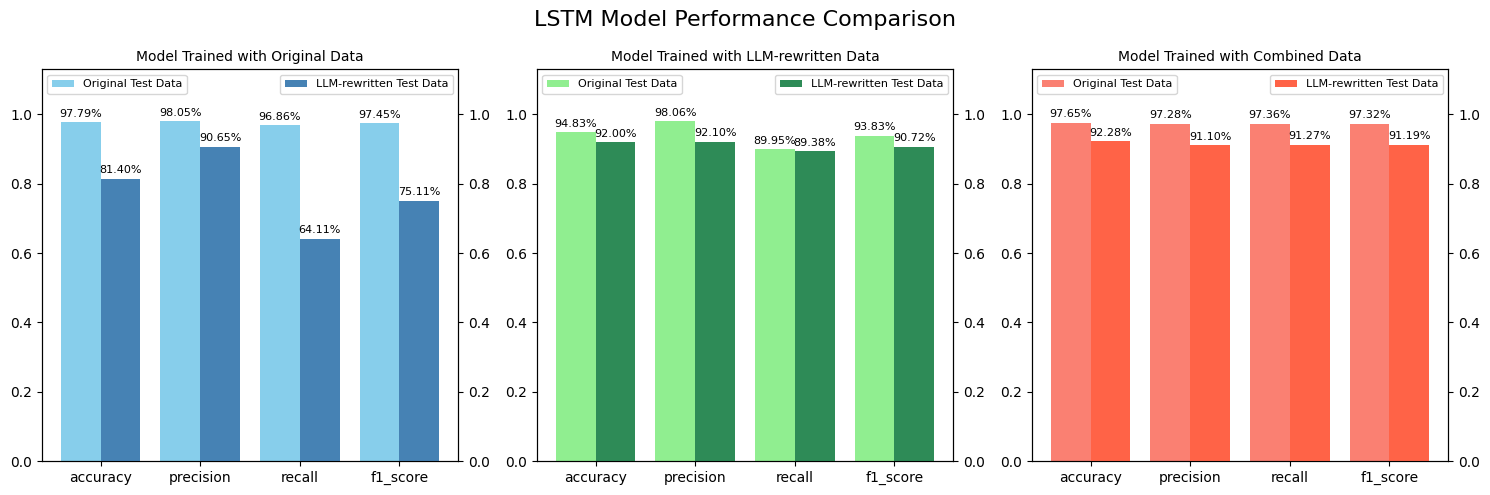

In [19]:

plot_results(
    model,
    perf_original_model_val_data,
    perf_original_model_val_data_rewritten,
    perf_combined_model_val_data,
    perf_combined_model_val_data_rewritten,
    perf_rewritten_model_val_data,
    perf_rewritten_model_val_data_rewritten,
)